# Tutorial 6 - External Function Interfacing
- There are many other existing Agentic Frameworks like Crew.ai, LangChain / LangGraph, LlamaIndex that have many pre-established tools
- TaskGen provides an easy way to interface with them and input them directly into TaskGen Agents!

- Future Works
    - In the future, you can import main tools from other frameworks / TaskGen native tools via `tools.py`
    - In the future, there will also be an easy way to upload / download TaskGen community-based tools via code :)

In [4]:
# !pip install taskgen-ai

In [1]:
# Set up API key and do the necessary imports
import os
from taskgen import *

os.environ['OPENAI_API_KEY'] = '<YOUR API KEY HERE>'

# Define your own Custom LLM

In [339]:
def custom_llm(system_prompt: str, user_prompt: str):
    ''' Here, we use OpenAI for illustration, you can change it to your own LLM '''
    # ensure your LLM imports are all within this function
    from openai import OpenAI
    
    # define your own LLM here
    client = OpenAI()
    response = client.chat.completions.create(
        model='gpt-3.5-turbo',
        temperature = 0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content

In [340]:
custom_llm('You are a classifier to classify the sentiment of a sentence', 'It is a hot and sunny day')

'Sentiment: Positive'

# Overview of Function Interfacing with TaskGen

## 1. Adding Python Function directly to Function
- You should write a docstring that describes the function and contains all the input variable names that are not `args`, `kwargs` or `shared_variables`
- typing for inputs and outputs will be automatically converted to TaskGen `Function` format

- **Smart Function Generator**: Even if you miss out the input type, or miss out output type, or have docstring without all input variables, or no docstring, we will smartly generate something out for you and the function can still be converted automatically to a Function

In [780]:
from typing import List, Dict

def add_number_to_list(num1: int, num_list: List[int], *args, **kwargs) -> List[int]:
    ''' Appends num1 to num_list '''
    num_list.append(num1)
    return num_list

In [781]:
fn = Function(external_fn = add_number_to_list)

In [782]:
print(fn)

Description:  Appends <num1: int> to <num_list: list[int]> 
Input: ['num1', 'num_list']
Output: {'output_1': 'list[int]'}



In [783]:
fn(7, [2, 3])

{'output_1': [2, 3, 7]}

## 2. Adding Python Function directly to Agent
- We can also assign the Python function directly to an Agent and it will automatically convert it to `Function` class

In [784]:
agent = Agent('Math Whiz', 'Does Math Calculations', llm = custom_llm).assign_functions([add_number_to_list])

In [785]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Use only after task is completed
Input: []
Output: {}

Name: add_number_to_list
Description:  Appends <num1: int> to <num_list: list[int]> 
Input: ['num1', 'num_list']
Output: {'output_1': 'list[int]'}



In [786]:
agent.run('Append 7 to [2, 4]')

Observation: No subtasks completed yet
Thoughts: To complete the assigned task of appending 7 to [2, 4], I need to use the 'add_number_to_list' function to add 7 to the list [2, 4].
Subtask identified: Add 7 to the list [2, 4]
Calling function add_number_to_list with parameters {'num1': 7, 'num_list': [2, 4]}
> {'output_1': [2, 4, 7]}

Observation: The task is to append 7 to the list [2, 4]. One subtask has been completed successfully, which is adding 7 to the list.
Thoughts: Since the subtask of adding 7 to the list has been completed, the remaining task is to end the task. This can be done by using the "end_task" function.
Subtask identified: End Task
Task completed successfully!



[{'output_1': [2, 4, 7]}]

# CrewAI Structured Tools Interface with TaskGen

In [10]:
# !pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [351]:
def query_pdf_tool(file_path: str, query: str):
    ''' Queries a pdf file at file_path using query and returns the relevant content '''
    from crewai_tools import PDFSearchTool
    
    return PDFSearchTool(pdf=file_path).run(query)

In [352]:
!wget https://arxiv.org/pdf/2210.03629 -O react.pdf

--2024-05-21 13:08:37--  https://arxiv.org/pdf/2210.03629
Resolving arxiv.org (arxiv.org)... 151.101.3.42, 151.101.67.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.3.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633805 (619K) [application/pdf]
Saving to: ‘react.pdf’

react.pdf           100%[===================>] 618.95K  --.-KB/s    in 0.02s   

2024-05-21 13:08:37 (27.6 MB/s) - ‘react.pdf’ saved [633805/633805]



In [353]:
query_pdf_tool('react.pdf', 'What is ReAct?')

Using Tool: Search a PDF's content


'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. Furthermore, on two interactive decision making benchmarks (ALFWorld and WebShop), ReAct outperforms imitation and reinforcement learning methods by an absolute success rate of 34% and 10% respectively, while being prompted with only one or two in-context examples. 1 I NTRODUCTION A unique featur

In [357]:
agent = Agent('PDF Query Agent', 'References react.pdf and answers a user query').assign_functions([query_pdf_tool])

In [358]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Use only after task is completed
Input: []
Output: {}

Name: query_pdf_tool
Description:  Queries a pdf file at <file_path: str> using <query: str> and returns the relevant content 
Input: ['file_path', 'query']
Output: {}



In [359]:
agent.reset()
agent.run('What is ReAct?')

Observation: 
Thoughts: To answer the question 'What is ReAct?', we need to refer to the react.pdf file to find the relevant information.
Subtask identified: Query the react.pdf file to find the definition and information about ReAct.
Calling function query_pdf_tool with parameters {'file_path': 'react.pdf', 'query': 'ReAct'}
Using Tool: Search a PDF's content
> {'output_1': 'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving t

[{'output_1': 'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. Furthermore, on two interactive decision making benchmarks (ALFWorld and WebShop), ReAct outperforms imitation and reinforcement learning methods by an absolute success rate of 34% and 10% respectively, while being prompted with only one or two in-context examples. 1 I NTRODUCTION A

In [360]:
agent.reply_user()

ReAct is a unique approach that integrates decision making and reasoning capabilities into a large language model. It is designed to interact with a simple Wikipedia API and generate human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. ReAct is intuitive and easy to design, general and flexible, and performant and robust. It shows strong generalization to new task instances.


'ReAct is a unique approach that integrates decision making and reasoning capabilities into a large language model. It is designed to interact with a simple Wikipedia API and generate human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. ReAct is intuitive and easy to design, general and flexible, and performant and robust. It shows strong generalization to new task instances.'

In [120]:
# just wrap the external tool within a function
def scrape_website_tool(website_url: str) -> str:
    ''' Scrapes data from website_url '''
    # import the tool
    from crewai_tools import ScrapeWebsiteTool
    
    # initialise the tool
    docs_scrape_tool = ScrapeWebsiteTool(
        website_url=website_url)
    
    # run the tool
    return docs_scrape_tool.run()

In [140]:
agent = Agent('Website summariser', 'Scrapes and then uses LLM to summarise a website to the user', 
              summarise_subtasks_count = 5).assign_functions([scrape_website_tool])

In [141]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Use only after task is completed
Input: []
Output: {}

Name: scrape_website_tool
Description:  Scrapes data from <website_url: str> 
Input: ['website_url']
Output: {'output_1': 'str'}



In [142]:
agent.run('What are the differences between TaskGen ("https://github.com/simbianai/taskgen") and CrewAI ("https://github.com/joaomdmoura/CrewAI")?')

Observation: No subtasks have been completed yet.
Thoughts: To complete the assigned task, we need to gather information on the differences between TaskGen and CrewAI. This can be achieved by scraping the respective websites and then summarising the content using LLM.
Subtask identified: Scrapes data from "https://github.com/simbianai/taskgen"
Calling function scrape_website_tool with parameters {'website_url': 'https://github.com/simbianai/taskgen'}
Using Tool: Read website content
> {'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\n Sign in\n Product\nActions\n Automate any workflow\nPackages\n Host and manage packages\nSecurity\n Find and fix vulnerabilities\nCodespaces\n Instant dev environments\nCopilot\n Write better code with AI\nCode review\n Manage code changes\nIssues\n Plan and track work\nDiscussions\n Collaborate outside of code\nExplore\n All features\n Documentation\n 

[{'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\n Sign in\n Product\nActions\n Automate any workflow\nPackages\n Host and manage packages\nSecurity\n Find and fix vulnerabilities\nCodespaces\n Instant dev environments\nCopilot\n Write better code with AI\nCode review\n Manage code changes\nIssues\n Plan and track work\nDiscussions\n Collaborate outside of code\nExplore\n All features\n Documentation\n GitHub Skills\n Blog\n Solutions\nFor\n Enterprise\n Teams\n Startups\n Education\nBy Solution\n CI/CD & Automation\n DevOps\n DevSecOps\nResources\n Learning Pathways\n White papers, Ebooks, Webinars\n Customer Stories\n Partners\n Open Source\nGitHub Sponsors\n Fund open source developers\nThe ReadME Project\n GitHub community articles\nRepositories\n Topics\n Trending\n Collections\nPricing\nSearch or jump to...\nSearch code, repositories, users, issues, pull requests...\n Search\n

In [143]:
agent.reply_user('What are the key imports needed?')

The key imports needed for TaskGen include importing the required functions from taskgen and using them. For CrewAI, the key imports involve importing various modules such as Agent, Task, Crew, Process, and SerperDevTool from crewai and crewai_tools packages.


'The key imports needed for TaskGen include importing the required functions from taskgen and using them. For CrewAI, the key imports involve importing various modules such as Agent, Task, Crew, Process, and SerperDevTool from crewai and crewai_tools packages.'

In [144]:
agent.reply_user('What version of packages are they compatible with?')

TaskGen and CrewAI are compatible with different versions of packages. TaskGen requires the package "taskgen-ai" to be installed, which can be done using "pip install taskgen-ai". For CrewAI, the package "crewai" needs to be installed, and additional tools can be included by using "pip install 'crewai[tools]'". Both frameworks may have dependencies on specific versions of Python and other libraries, so it is essential to refer to their respective documentation for detailed compatibility information.


'TaskGen and CrewAI are compatible with different versions of packages. TaskGen requires the package "taskgen-ai" to be installed, which can be done using "pip install taskgen-ai". For CrewAI, the package "crewai" needs to be installed, and additional tools can be included by using "pip install \'crewai[tools]\'". Both frameworks may have dependencies on specific versions of Python and other libraries, so it is essential to refer to their respective documentation for detailed compatibility information.'

# LangChain Structured Tools Interface with TaskGen
- If User defines a function in LangChain, simply just add <fn_name>.func to TaskGen Agent

In [149]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


tools = [add, multiply]

In [150]:
from taskgen import Agent
agent = Agent('Math Whiz', 'Does calculations').assign_functions([add.func, multiply.func])

In [151]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Use only after task is completed\nInput: []\nOutput: {}\n',
 "Name: add\nDescription: Adds <a: int> and <b: int>.\nInput: ['a', 'b']\nOutput: {'output_1': 'int'}\n",
 "Name: multiply\nDescription: Multiplies <a: int> and <b: int>.\nInput: ['a', 'b']\nOutput: {'output_1': 'int'}\n"]

In [152]:
agent.run('Calculate 3*5+3')

Observation: No subtasks completed yet.
Thoughts: To calculate 3*5+3, we need to first multiply 3 and 5, then add 3 to the result.
Subtask identified: Multiply 3 and 5.
Calling function multiply with parameters {'a': 3, 'b': 5}
> {'output_1': 15}

Observation: The task is to calculate 3*5+3. The subtask of multiplying 3 and 5 has been completed successfully.
Thoughts: Since the multiplication of 3 and 5 has been done, the next step is to add 3 to the result of the multiplication to complete the calculation. This can be achieved by using the "add" function with the result of the multiplication and 3 as inputs.
Subtask identified: Add 3 to the result of multiplying 3 and 5.
Calling function add with parameters {'a': 15, 'b': 3}
> {'output_1': 18}

Observation: The Assigned Task is to calculate 3*5+3. Two subtasks have been completed: multiplying 3 and 5 to get 15, and adding 3 to the result of multiplying 3 and 5 to get 18.
Thoughts: To complete the remainder of the Assigned Task, we nee

['The calculation for 3*5+3 is already completed. The result is 18.']

# LangChain Community Tools Interface with TaskGen
- See https://python.langchain.com/v0.2/docs/integrations/providers/ for full list
- Wikipedia
- Python REPL (not that great to run many things - have created my own in TaskGen)

In [71]:
# !pip -q install wikipedia

In [153]:
def wikipedia_tool(search_query: str) -> str:
    ''' Uses search_query and returns text from wikipedia '''
    from langchain.tools import WikipediaQueryRun
    from langchain.utilities import WikipediaAPIWrapper

    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(search_query)

In [154]:
wikipedia_tool('Joe Biden')[:100]

'Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (  BY-dən; born November 20, 1942) is an America'

In [8]:
# !pip install --upgrade --quiet  duckduckgo-search

In [155]:
## Note: Rate Limit reached
def duckduckgo_search_tool(search_query: str) -> str:
    ''' Returns the result of duckduckgo search tool with search_query '''
    from langchain_community.tools import DuckDuckGoSearchRun
    return DuckDuckGoSearchRun().run(search_query)

In [10]:
# duckduckgo_search_tool('What are 5 good restaurants in Singapore?')

In [156]:
def python_repl_tool(python_code: str) -> str:
    ''' Runs python_code, returns the final result, or any debugging errors '''
    from langchain.utilities import PythonREPL
    
    return PythonREPL().run(python_code)

In [157]:
python_repl_tool('print(3+5)')

2024-05-21 10:56:00,758 - 140704271009536 - python.py-python:16 - WARNING: Python REPL can execute arbitrary code. Use with caution.


'8\n'

# TaskGen Custom Tools
- Some initial tools TaskGen can provide are as follows:
    - Code generator: `python_generator_tool`
    - Code executor: `python_run_tool`
    - Code debugger: `python_debug_tool`
    - Code generator, executor and debugger combined: `python_generate_and_run_code_tool`
    - Webpage parser: `get_text_from_url_tool`

In [758]:
python_generator_tool = Function('''Generate code based only on <instruction: str> without additional context.
    Ensure that you define all variables and list out all imports.
    You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
    Do not define any functions
    You are not able to use the Equipped Functions using this tool.
    Ensure all required output are in print statements''',
                                     output_format = {'Output Code': 'type: code'}, fn_name = 'python_generator_tool')

In [759]:
python_generator_tool('What is 2+3?')

{'Output Code': 'result = 2 + 3\nprint(result)'}

In [760]:
def python_run_tool(code_snippet: str) -> str:
    '''Runs code_snippet and outputs the result of all print statements'''
    import sys
    import io
    import math
    import numpy
    import random
    import datetime
    import re
    import matplotlib
    import pandas
    import plotly

    # Disable file access
    def restricted_open(*args, **kwargs):
        raise PermissionError("File access is restricted")
    
    # Capture the output
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()

    try:
        # Safe environment to execute the user code
        allowed_globals = {
            '__builtins__': {
                'print': print,
                'range': range,
                'len': len,
                'int': int,
                'float': float,
                'str': str,
                'list': list,
                'dict': dict,
                'set': set,
                'tuple': tuple,
                'abs': abs,
                'min': min,
                'max': max,
                'sum': sum,
                'any': any,
                'all': all,
                'sorted': sorted,
                'zip': zip,
                'map': map,
                'filter': filter,
                '__import__': __import__,
                'math': math,  # Allow access to the math module
                'datetime': datetime, # Allow access to datetime module
                'random': random, # Allow access to random module
                'numpy': numpy, # Allow access to numpy module
                're': re,
                'matplotlib': matplotlib,
                'pandas': pandas,
                'plotly': plotly,
                'open': restricted_open,  # Override open to restrict file access
            }
        }

        safe_locals = {}

        exec(code_snippet, allowed_globals, safe_locals)
        output = sys.stdout.getvalue()
    except Exception as e:
        output = f"Error: {e}"
    finally:
        # Restore the original stdout
        sys.stdout = old_stdout

    return output

In [761]:
python_run_tool('print("This is a great tool to debug and run code!")\nprint("Awesome!")')

'This is a great tool to debug and run code!\nAwesome!\n'

In [762]:
python_debug_tool = Function('''Debugs Python Code and returns corrected code.
Instruction: <instruction: str>
Current Code: <python_code: str>
Error Message: <error_msg: str>''',
                                 output_format = {'Thoughts': 'How to correct code', 'Corrected Code': 'type: code'}, fn_name = 'python_debug_tool')

In [763]:
python_debug_tool('Print result', 'result = 3print(result)', 'invalid decimal literal (<string>, line 1)')

{'Thoughts': 'The error message indicates that there is an issue with the decimal literal in the code. We need to add a space between the number 3 and the print statement.',
 'Corrected Code': 'result = 3\nprint(result)'}

## Combining all Python Code tools into one
- This is like a rule-based agent, doing the three functions inside it, so that we don't have to keep passing in code as input variable to the functions
- This is also a context-based function, taking in agent's overall task and subtasks completed via shared_variables
- Do note that you need to pass in the agent as the shared_variables to utilise this function (to be done by default in future versions of TaskGen)

In [764]:
# Uses LLM to generate Code
def python_generate_and_run_code_tool(shared_variables, instruction: str) -> str:
    ''' Generates and runs code based on instruction. Returns 1) the result of all print statements in code, or error messages, and 2) the code '''
    # from termcolor import colored
    
    # Append context to tool
    if shared_variables and 'agent' in shared_variables:
        instruction = f"Context: {shared_variables['agent'].overall_task}\nPrevious Subtasks: {shared_variables['agent'].subtasks_completed}\nInstruction: {instruction}"
    # Generate Code
    python_code = python_generator_tool(instruction)['Output Code']
    # print(colored(f'Generated code: ```{python_code}```', 'magenta'))
    
    # Run and Debug Code
    for _ in range(3):
        output = python_run_tool(python_code)

        if output[:5] == "Error":
            debugged_code = python_debug_tool(instruction, python_code, output)
            python_code = debugged_code['Corrected Code']
            # print(colored(output, 'red'))
            # print(colored(f'Debugged code: ```{python_code}```', 'magenta'))
        else:
            break
            
    return output, python_code

In [765]:
python_code_tool(None, 'Give me first 10 primes, without 2 and 5')

('[3, 7, 11, 13, 17, 19, 23, 29, 31, 37]\n',
 'primes = [3, 7, 11, 13, 17, 19, 23, 29, 31, 37]\nprint(primes)')

In [766]:
def get_text_from_url_tool(url) -> str:
    ''' Returns text from a url '''
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from webdriver_manager.chrome import ChromeDriverManager
    from selenium.webdriver.chrome.options import Options
    from bs4 import BeautifulSoup
    from bs4.element import Comment
    
    # Maximum character length
    MAX_LEN = 10000

    def tag_visible(element):
        if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
            return False
        if isinstance(element, Comment):
            return False
        return True

    def text_from_html(body):
        soup = BeautifulSoup(body, 'html.parser')
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
        return text

    # Create an instance of Options
    options = Options()

    # Set the option for headless
    options.headless = True

    # Set up the WebDriver with the ChromeDriverManager and options
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    driver.implicitly_wait(2)
    # Open the webpage
    driver.get(url)

    html = driver.page_source

    # Close the driver
    driver.quit()

    return text_from_html(html)[:MAX_LEN]

In [771]:
agent = Agent('Generalist Agent', 
'''Helps user with tasks. When deterministic output is needed, generate and run code. Do not use LLM for calculations. End task if you need to output to user.''', 
             summarise_subtasks_count = 10).assign_functions(
    [wikipedia_tool, python_code_tool, get_text_from_url_tool])

# assign shared variables for agent so code tool can get context of the task
agent.shared_variables['agent'] = agent

In [772]:
agent.reset()
agent.run('John has 5 apples. John received another 21 more from Mary, and gave 10 to Tim. How many apples does John have at the end?')

Observation: No subtasks have been completed yet.
Thoughts: To complete the remainder of the assigned task, we need to calculate the final number of apples John has after receiving 21 more from Mary and giving 10 to Tim. We can achieve this by performing simple arithmetic operations.
Subtask identified: Calculate the final number of apples John has after receiving 21 more from Mary and giving 10 to Tim.
Calling function python_code_tool with parameters {'instruction': 'Calculate the final number of apples John has after receiving 21 more from Mary and giving 10 to Tim.'}
> {'output_1': 'John has 16 apples at the end\n', 'output_2': 'john_apples = 5\njohn_apples += 21\njohn_apples -= 10\nprint("John has", john_apples, "apples at the end")'}

Observation: The current subtask involves determining the final number of apples John has after receiving 21 more from Mary and giving 10 to Tim. The calculation has been completed successfully using Python code.
Thoughts: To complete the remainder 

[{'output_1': 'John has 16 apples at the end\n',
  'output_2': 'john_apples = 5\njohn_apples += 21\njohn_apples -= 10\nprint("John has", john_apples, "apples at the end")'},
 {'output_1': 'John has 16 apples at the end\n',
  'output_2': 'john_apples = 5\njohn_apples += 21\njohn_apples -= 10\nprint("John has", john_apples, "apples at the end")'}]

In [773]:
agent.reply_user()

John has 16 apples at the end


'John has 16 apples at the end'

Observation: No subtasks have been completed yet.
Thoughts: To plot a graph of y = 2x^2, we need to generate the code for plotting the graph using a Python plotting library like Matplotlib. We can use the python_code_tool function to generate the necessary code for plotting the graph.
Subtask identified: Generate and run Python code to plot the graph of y = 2x^2 using Matplotlib.
Calling function python_code_tool with parameters {'instruction': 'Generate and run Python code to plot the graph of y = 2x^2 using Matplotlib.'}


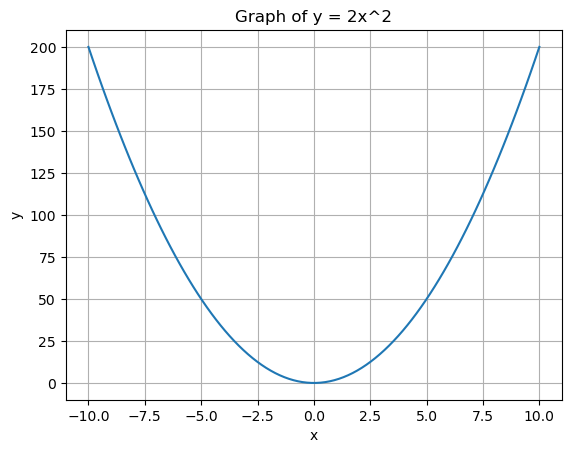

> {'output_1': '', 'output_2': 'import matplotlib.pyplot as plt\nimport numpy as np\n\nx = np.linspace(-10, 10, 100)\ny = 2 * x**2\n\nplt.plot(x, y)\nplt.xlabel("x")\nplt.ylabel("y")\nplt.title("Graph of y = 2x^2")\nplt.grid(True)\nplt.show()'}

Observation: The graph of y = 2x^2 has been successfully plotted using Matplotlib in Python.
Thoughts: Since the graph has been plotted, the next step is to end the task as there are no further subtasks to be completed.
Subtask identified: End Task
Task completed successfully!



[{'output_1': '',
  'output_2': 'import matplotlib.pyplot as plt\nimport numpy as np\n\nx = np.linspace(-10, 10, 100)\ny = 2 * x**2\n\nplt.plot(x, y)\nplt.xlabel("x")\nplt.ylabel("y")\nplt.title("Graph of y = 2x^2")\nplt.grid(True)\nplt.show()'}]

In [774]:
agent.reset()
agent.run('Plot me a graph of y = 2x^2')

In [775]:
agent.reset()
agent.run('What are the first 10 prime numbers?')

Observation: No subtasks have been completed yet.
Thoughts: To find the first 10 prime numbers, we can use a simple algorithm to check for prime numbers. We can start by checking numbers starting from 2 and keep track of the prime numbers found until we have the first 10.
Subtask identified: Generate and run code to find the first 10 prime numbers.
Calling function python_code_tool with parameters {'instruction': 'Generate and run code to find the first 10 prime numbers.'}
> {'output_1': 'The first 10 prime numbers are: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n', 'output_2': 'import math\n\nprimes = []\nnum = 2\n\nwhile len(primes) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        primes.append(num)\n    num += 1\n\nprint("The first 10 prime numbers are:", primes)'}

Observation: The first 10 prime numbers have been successfully generated using code.
Thoughts: Si

[{'output_1': 'The first 10 prime numbers are: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n',
  'output_2': 'import math\n\nprimes = []\nnum = 2\n\nwhile len(primes) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        primes.append(num)\n    num += 1\n\nprint("The first 10 prime numbers are:", primes)'}]

In [776]:
agent.reset()
agent.run('Who is Joe Biden and how old is he now based on calculation?')

Observation: No subtasks have been completed yet for the assigned task.
Thoughts: To complete the assigned task, we need to find information about Joe Biden and calculate his current age. We can use the Wikipedia tool to gather information about Joe Biden and then calculate his current age based on his birthdate.
Subtask identified: Uses "Joe Biden" to gather information from Wikipedia
Calling function wikipedia_tool with parameters {'search_query': 'Joe Biden'}
> {'output_1': "Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (  BY-dən; born November 20, 1942) is an American politician who is the 46th and current president of the United States since 2021. A member of the Democratic Party, he previously served as the 47th vice president from 2009 to 2017 under President Barack Obama and represented Delaware in the United States Senate from 1973 to 2009.\nBorn in Scranton, Pennsylvania, Biden moved with his family to Delaware in 1953. He graduated from the University of Delaware befo

[{'output_1': "Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (  BY-dən; born November 20, 1942) is an American politician who is the 46th and current president of the United States since 2021. A member of the Democratic Party, he previously served as the 47th vice president from 2009 to 2017 under President Barack Obama and represented Delaware in the United States Senate from 1973 to 2009.\nBorn in Scranton, Pennsylvania, Biden moved with his family to Delaware in 1953. He graduated from the University of Delaware before earning his law degree from Syracuse University. He was elected to the New Castle County Council in 1970 and to the U.S. Senate in 1972. As a senator, Biden drafted and led the effort to pass the Violent Crime Control and Law Enforcement Act and the Violence Against Women Act. He also oversaw six U.S. Supreme Court confirmation hearings, including the contentious hearings for Robert Bork and Clarence Thomas. Biden ran unsuccessfully for the Democratic president

In [777]:
agent.reply_user()

Joe Biden is an American politician who is the 46th and current president of the United States. He was born on November 20, 1942. Based on calculation, Joe Biden is currently 81 years old in 2023.


'Joe Biden is an American politician who is the 46th and current president of the United States. He was born on November 20, 1942. Based on calculation, Joe Biden is currently 81 years old in 2023.'

In [778]:
agent.reset()
agent.run('What are the number of stars in TaskGen GitHub? (https://github.com/simbianai/taskgen)')

Observation: No subtasks have been completed yet.
Thoughts: To find the number of stars in the TaskGen GitHub repository, we can use the get_text_from_url_tool function to extract the required information from the GitHub page. We will then need to parse the text to find the number of stars.
Subtask identified: Use the get_text_from_url_tool function to extract text from the GitHub page of TaskGen (https://github.com/simbianai/taskgen).
Calling function get_text_from_url_tool with parameters {'url': 'https://github.com/simbianai/taskgen'}
> {'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\nSign in\nProduct\nActions\nAutomate any workflow\nPackages\nHost and manage packages\nSecurity\nFind and fix vulnerabilities\nCodespaces\nInstant dev environments\nCopilot\nWrite better code with AI\nCode review\nManage code changes\nIssues\nPlan and track work\nDiscussions\nCollaborate outside of c

[{'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\nSign in\nProduct\nActions\nAutomate any workflow\nPackages\nHost and manage packages\nSecurity\nFind and fix vulnerabilities\nCodespaces\nInstant dev environments\nCopilot\nWrite better code with AI\nCode review\nManage code changes\nIssues\nPlan and track work\nDiscussions\nCollaborate outside of code\nExplore\nAll features\nDocumentation\nGitHub Skills\nBlog\nSolutions\nFor\nEnterprise\nTeams\nStartups\nEducation\nBy Solution\nCI/CD & Automation\nDevOps\nDevSecOps\nResources\nLearning Pathways\nWhite papers, Ebooks, Webinars\nCustomer Stories\nPartners\nOpen Source\nGitHub Sponsors\nFund open source developers\nThe ReadME Project\nGitHub community articles\nRepositories\nTopics\nTrending\nCollections\nPricing\nSearch or jump to...\nSearch code, repositories, users, issues, pull requests...\nSearch\nClear\nSearch syntax tips\nProvid

In [779]:
agent.reply_user()

The number of stars in TaskGen GitHub is 77.


'The number of stars in TaskGen GitHub is 77.'

# LlamaIndex Function Interface with TaskGen
- If User defines a function in LlamaIndex, simply just add <fn_name>.fn to TaskGen Agent
- TODO: Add structure for other kinds of functions in LlamaIndex

In [332]:
from llama_index.core.tools import FunctionTool

def get_weather(location: str) -> str:
    """Usfeful for getting the weather for a given location."""
    return 'Sunny'
    ...

tool = FunctionTool.from_defaults(
    get_weather,
    # async_fn=aget_weather,  # optional!
)

In [333]:
agent = Agent('Weather Agent', 'Returns the Weather').assign_functions(tool.fn)

In [334]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Use only after task is completed\nInput: []\nOutput: {}\n',
 "Name: get_weather\nDescription: Usfeful for getting the weather for a given <location: str>.\nInput: ['location']\nOutput: {'output_1': 'str'}\n"]

In [335]:
agent.run('What is the weather in Miami?')

Observation: No subtasks completed yet
Thoughts: Since no subtasks have been completed yet, the first step would be to use the get_weather function to retrieve the weather information for the specified location, which in this case is Miami.
Subtask identified: Retrieve the weather information for Miami
Calling function get_weather with parameters {'location': 'Miami'}
> {'output_1': 'Sunny'}

Observation: The weather information for Miami has been retrieved successfully (Sunny).
Thoughts: Since the weather information for Miami has been obtained, the next step is to end the task.
Subtask identified: End Task
Task completed successfully!



[{'output_1': 'Sunny'}]